In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
from aps_ai.beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob

In [ ]:
%matplotlib inline

In [ ]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

In [ ]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'
temp_work_dir = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'

In [ ]:
os.mkdir(temp_work_dir)

In [ ]:
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [ ]:
os.chdir(temp_work_dir)

In [ ]:
input_beam_path = "primary_optics_system_beam.dat"

In [ ]:
move_motors = ['vkb_q']

In [ ]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [ ]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

In [ ]:
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system=focusing_system, 
                                                                random_seed=DEFAULT_RANDOM_SEED)
print(centroid)
_ = plot_shadow_beam_spatial_distribution(out_beam)

In [ ]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

In [ ]:
# check positive and negative movement
movers.move_motors(focusing_system, move_motors, -100, movement='relative')
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)
movers.move_motors(focusing_system, move_motors, initial_absolute_positions, movement='absolute')

In [ ]:
# check positive and negative movement
movers.move_motors(focusing_system, move_motors, 100, movement='relative')
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)
movers.move_motors(focusing_system, move_motors, initial_absolute_positions, movement='absolute')

In [ ]:
# Plotting the loss function for a grid of values

In [ ]:
test_values = np.linspace(-100, 100, 20)
fwhm_values = []
for v in tqdm(test_values):
    focusing_system = movers.move_motors(focusing_system, move_motors, v, movement='relative')
    fwhm, out_beam, *_ = opt_common.get_fwhm(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    focusing_system = movers.move_motors(focusing_system, move_motors, initial_absolute_positions, movement='absolute')
    fwhm_values.append(fwhm)

In [ ]:
plt.plot(test_values + initial_absolute_positions[0], fwhm_values)
plt.xlabel('Position')
plt.ylabel('FWHM')
plt.show()

In [ ]:
initial_losses = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_losses = []
final_out_beams = []
opt_results_all_scipy = []

min_trans = -100
max_trans = 100

for outer in tqdm(range(5)):
    translations = np.random.uniform(min_trans, max_trans, size=1)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    fwhm, out_beam, hist, dw = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_losses.append(fwhm)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameter='fwhm',
                                              default_opt_params={'xatol':1e-1 'fatol':5e-4})
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=True, 
                                                               guess_min=min_trans, 
                                                               guess_max=max_trans)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    fwhm, out_beam, *_ = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_losses.append(fwhm)
    final_out_beams.append(out_beam)
    opt_results_all_scipy.append(opt_results)
    print(f'Test {outer} success {success}')

In [57]:
nfevs_scipy = [[ors.nfev for ors in opt_results_list] for opt_results_list in opt_results_all_scipy]
print(nfevs_scipy, np.mean([np.sum(nfs) for nfs in nfevs_scipy]))

[[39], [21], [11], [31], [25, 25]] 30.4


In [58]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [59]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [60]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [61]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

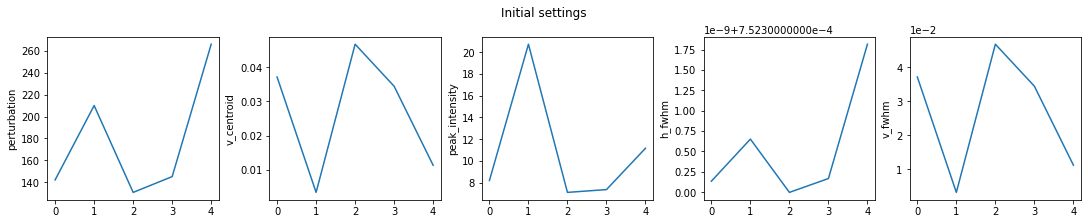

In [62]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

axes[1].plot(initial_losses)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

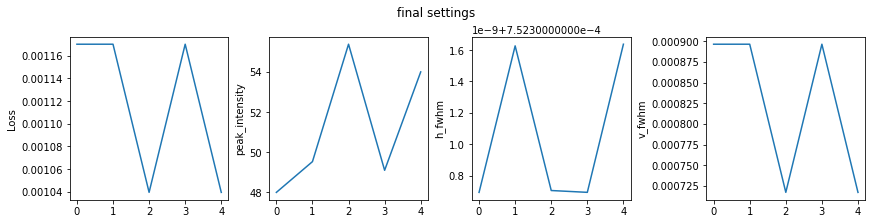

In [63]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_losses)
axes[0].set_ylabel('Loss')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

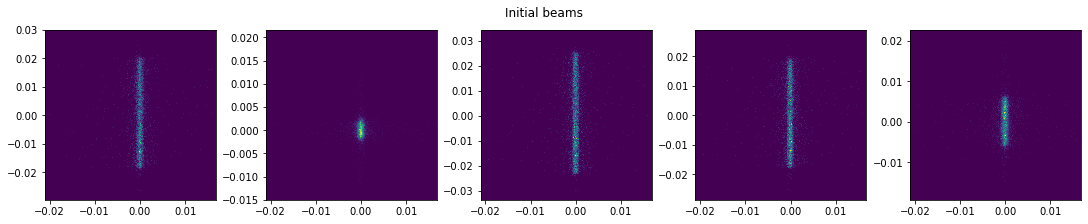

In [64]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

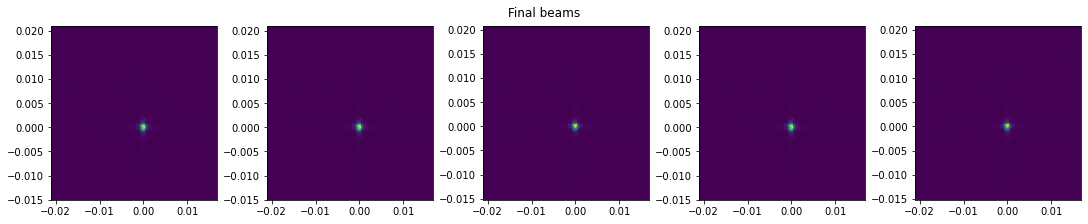

In [65]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

In [66]:
# Test gaussian process optimization

In [67]:
import skopt

In [68]:
callback_y = skopt.callbacks.DeltaYStopper(1e-3)
callback_x = skopt.callbacks.DeltaXStopper(1e-1)

In [69]:
%%time
initial_losses = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_losses = []
final_out_beams = []
opt_results_all_gp = []

min_trans = -100.
max_trans = 100.

for outer in tqdm(range(10)):
    translations = np.random.uniform(min_trans, max_trans, size=1)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    fwhm, out_beam, hist, dw = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_losses.append(fwhm)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameter='fwhm')
    opt_trial.set_gaussian_process_optimizer(bounds=[min_trans, max_trans], callback=[callback_x, callback_y])
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=True, guess_min=min_trans, guess_max=max_trans)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    fwhm, out_beam, *_ = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_losses.append(fwhm)
    final_out_beams.append(out_beam)
    opt_results_all_gp.append(opt_results)
    print(f'Test {outer} success {success} with final x {opt_results[-1].x} and final value {opt_results[-1].fun}')

  0%|          | 0/10 [00:00<?, ?it/s]

Initial motor positions are [160.07423071]
motors ['vkb_q'] trans [0.] current loss 0.02558074681942612
Initial loss is 0.02558074681942612
motors ['vkb_q'] trans [-88.79103307] current loss 0.1446567716289289
motors ['vkb_q'] trans [12.36331689] current loss 0.018436366616645397
motors ['vkb_q'] trans [70.76248599] current loss 0.0029730311313613585
motors ['vkb_q'] trans [60.34328768] current loss 0.0011703595001940283
motors ['vkb_q'] trans [14.60052349] current loss 0.017466647021733908
motors ['vkb_q'] trans [-90.60839254] current loss 0.15033596377070932
motors ['vkb_q'] trans [78.44543342] current loss 0.004566353856060374
motors ['vkb_q'] trans [-75.01159517] current loss 0.1099129523042352
motors ['vkb_q'] trans [-93.84356154] current loss 0.16120624462670324
motors ['vkb_q'] trans [-67.93745828] current loss 0.09602023940914622
motors ['vkb_q'] trans [100.] current loss 0.009878595907695006
motors ['vkb_q'] trans [41.74473856] current loss 0.0063422814411352784
motors ['vkb_q

 10%|█         | 1/10 [01:22<12:19, 82.16s/it]

Test 0 success True with final x [59.41231068268959] and final value 0.0011702862846689856
Initial motor positions are [279.02018703]
motors ['vkb_q'] trans [0.] current loss 0.013704015179259696
Initial loss is 0.013704015179259696
motors ['vkb_q'] trans [-46.44102497] current loss 0.003323794529269632
motors ['vkb_q'] trans [-84.48728023] current loss 0.00879142999942666
motors ['vkb_q'] trans [94.88352375] current loss 0.027201886961034483
motors ['vkb_q'] trans [-70.18363122] current loss 0.00393034529068989
motors ['vkb_q'] trans [9.75750769] current loss 0.016006194019150065
motors ['vkb_q'] trans [89.15439845] current loss 0.027172941310379912
motors ['vkb_q'] trans [59.81965152] current loss 0.02388038771831141
motors ['vkb_q'] trans [65.55474003] current loss 0.024253120660965667
motors ['vkb_q'] trans [40.46855734] current loss 0.020936182152046463
motors ['vkb_q'] trans [-41.68272363] current loss 0.004387409744552702
motors ['vkb_q'] trans [-18.37451092] current loss 0.0097

 10%|█         | 1/10 [02:06<19:00, 126.70s/it]


KeyboardInterrupt: 

In [51]:
opt_results_all

[[          fun: 0.001124024321766941
      func_vals: array([0.00475451, 0.00611564, 0.03422501, 0.07932494, 0.01093587,
         0.09773161, 0.00560925, 0.08274056, 0.01029174, 0.01077348,
         0.00128807, 0.01307117, 0.01148453, 0.00239659, 0.00828721,
         0.00124683, 0.00123604, 0.01184341, 0.00112402, 0.01884088,
         0.00113031])
         models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                           n_restarts_optimizer=2, noise='gaussian',
                           normalize_y=True, random_state=558083384), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                           n_restarts_optimizer=2, noise='gaussian',
                           normalize_y=True, random_state=558083384), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                           n_restarts_optimizer=2, no

In [52]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [53]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [54]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [55]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

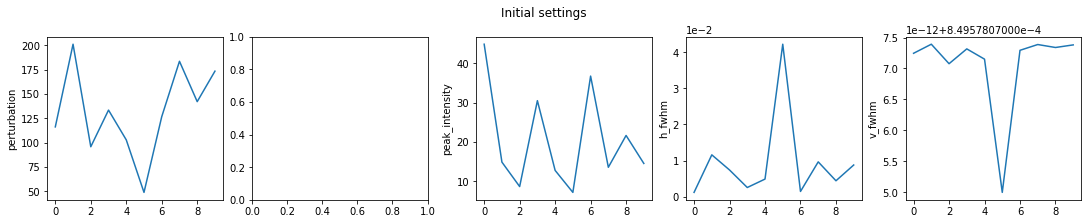

In [57]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

#axes[1].plot(initial_centroids)
#axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

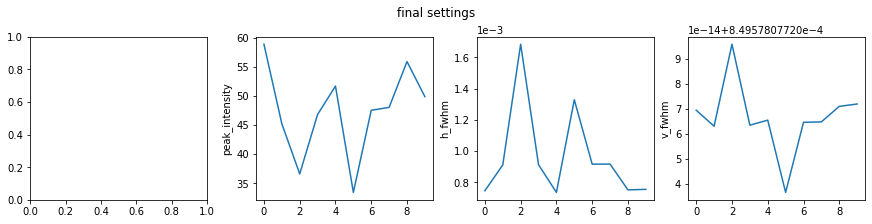

In [58]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

#axes[0].plot(final_centroids)
#axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

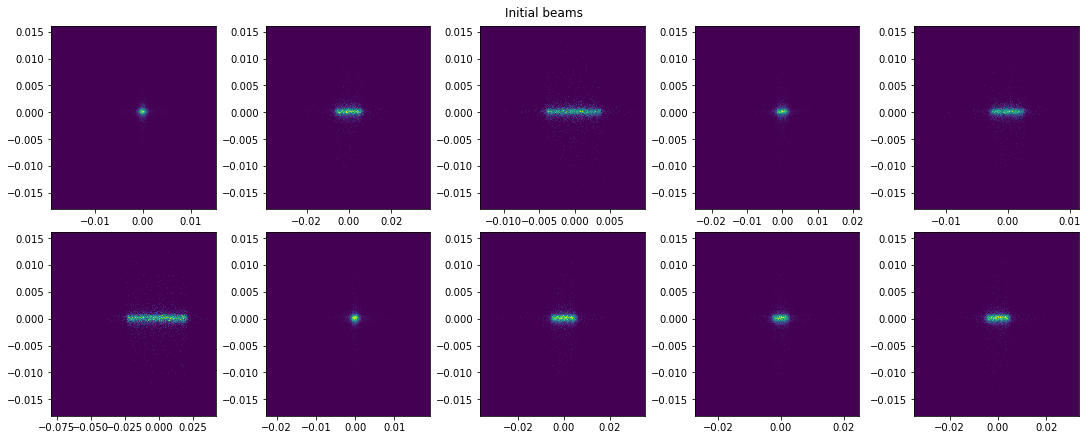

In [59]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

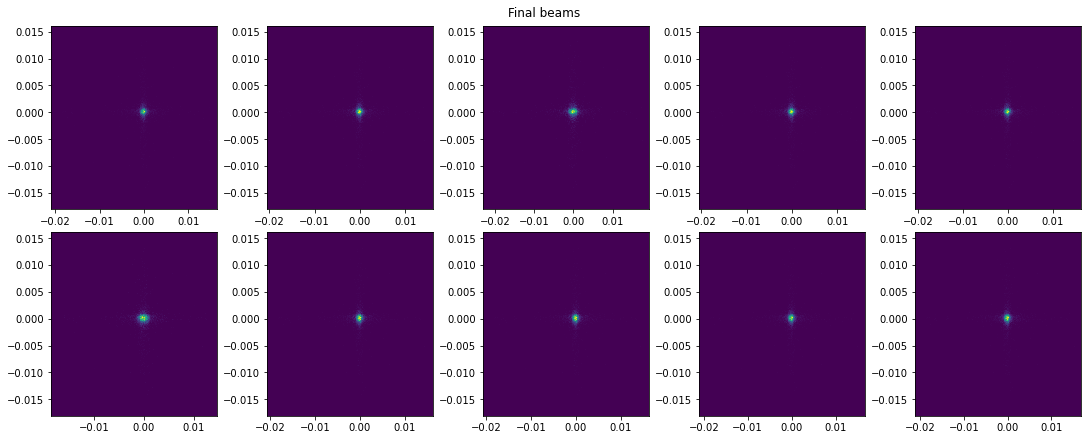

In [60]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

In [25]:
clean_up()

In [26]:
shutil.rmtree(temp_work_dir)